In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gym

In [2]:
class policy_net(nn.Module):
    
    def __init__(self, env, layers = 16):
        super().__init__()
        self.env = env
        self.S = env.observation_space.shape[0]
        self.A = env.action_space.n
        self.fc1 = nn.Linear(self.S, layers)
        self.fc2 = nn.Linear(layers, self.A)
        
    def forward(self, x):
        out1 = F.relu(self.fc1(x))
        out2 = F.softmax(self.fc2(out1), dim = 1)
        return torch.squeeze(out2)     #in case we take a single input of size (1, S), to make it just of size A

class baseline_net(nn.Module):
    
    def __init__(self, env, layers = 16):
        super().__init__()
        self.env = env
        self.S = env.observation_space.shape[0]
        self.fc1 = nn.Linear(self.S, layers)
        self.fc2 = nn.Linear(layers, 1)
        
    def forward(self, x):
        out1 = F.relu(self.fc1(x))
        out2 = self.fc2(out1)
        return torch.squeeze(out2)   #in case we take a single input of size (1, S), to make it just of size 1

In [3]:
class PG():
    
    def __init__(self, env, policy_layers, baseline_layers, gamma):
        self.env = env
        self.S = env.observation_space.shape[0]
        self.A = env.action_space.n
        self.policy_net = policy_net(env, policy_layers)
        self.baseline_net = baseline_net(env, baseline_layers)
        self.gamma = gamma
    
    def transform_rewards(self, rewards, gamma):
        '''It takes a list of rewards, rewards = [r1, r2,..., rT] and a gamma
        and transforms it to G with
        G1 = r1 + gamma*r2 + ... + gamma^{T-1}rT
        G2 = r2 + gamma*r3 + ... + gamma^{T-2}rT etc.
        Finally it returns this list'''
        
        T = len(rewards)
        
        for i in range(T-1, -1, -1):
            if i < T-1:
                rewards[i] = rewards[i] + gamma * rewards[i+1]
        return rewards
    
    def act(self, s):
        '''Takes a point s of the action space S and calculates policy_net(s).
        Then from the A-points (a1,...,aA) that sum to 1, samples one point 
        according to the distribution.
        Then it returns the chosen index, together with the value of the network computed on this index.'''
        output = self.policy_net(s.view(1, self.S))
        action = torch.multinomial(output, 1)
        return action, output[action]
    
    def train(self, iterations, episode_length, m_samples = 1, learning_rate = 0.001):
        '''It trains for iterations- times and each episode last episode_length- episodes.
        m_sample is the number we use to approximate the mean value'''
        rewards_history = []
        policy_opt = torch.optim.Adam(self.policy_net.parameters(), lr = learning_rate)
        baseline_opt = torch.optim.Adam(self.baseline_net.parameters(), lr = learning_rate)
        
        for iteration in range(iterations):
            G = torch.zeros((m_samples, episode_length))
            Baselines = torch.zeros((m_samples, episode_length))
            log_policies = torch.zeros((m_samples, episode_length))
            
            for m in range(m_samples):
                s = torch.tensor(self.env.reset(), dtype = torch.float32)
            
                for episode in range(episode_length):
                    a, net_value = self.act(s)
                    obs, reward, done, _ = self.env.step(int(np.array(a)))
                    G[m][episode] = torch.tensor(reward, dtype = torch.float32)
                    Baselines[m][episode] = self.baseline_net(s.view(1, self.S))
                    log_policies[m][episode] = torch.log(net_value)
                
                    s = torch.tensor(obs, dtype = torch.float32)
                   # print(done)
                    if done :
                        break
                        
                #Normalize, and then transform the rewards.
         #       G[m] = (G[m] - G[m].mean())/G[m].std()  
                G[m] = self.transform_rewards(G[m], self.gamma)
                #G[m] = (G[m] - G[m].mean())/G[m].std()  
            
            #In loss_1 I put the - because I want to take a step in the opposite direction
            #More precicely I want to maximize the expected reward, i.e. minimize - expected reward
        
            loss_1 = -((G - Baselines) * log_policies).sum()
            loss_2 =  ((G - Baselines) ** 2).sum()
            
            self.policy_net.zero_grad()
            policy_opt.zero_grad()
          
            loss_1.backward(retain_graph = True)
            policy_opt.step()
                        
            self.baseline_net.zero_grad()
            baseline_opt.zero_grad()
            loss_2.backward()
            baseline_opt.step()
            
            rewards_history.append(int(np.array(G.sum(dim = 1).mean())))
        
        return self.policy_net, self.baseline_net, rewards_history                                          

In [4]:
%%time
env = gym.make('LunarLander-v2')
env.reset()

pg = PG(env, 128, 128, 0.99)
policy_network, baseline_network, rewards = pg.train(5000, 200, 1, 0.001)

CPU times: user 28min 30s, sys: 54.5 s, total: 29min 24s
Wall time: 14min 44s


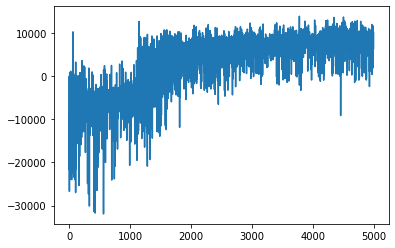

In [5]:
plt.plot(rewards)

In [7]:
env_to_wrap = gym.make('LunarLander-v2')
env = gym.wrappers.Monitor(env_to_wrap, 'video_file_1', force = True)

s = torch.tensor(env.reset(), dtype = torch.float32).view(1,8)
rewards = 0
for t in range(200):
    output = policy_network(s)
    action = int(np.array(torch.multinomial(output, 1)))
    #action = env.action_space.sample()
    obs, rew, done, _ = env.step(action)
    rewards += rew
    if done:
        print(t)
        break
    s = torch.tensor(obs, dtype = torch.float32).view(1,8)
    env.render()
    
env.close()
env_to_wrap.close()
rewards

141.3371170909395